# Maximum Likelihood Estimation (MLE)

In [1]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

In [2]:
# matplotlib configuration
import matplotlib as mpl
mpl.rcParams["axes.labelsize"] = 18
mpl.rcParams["axes.titlesize"] = 20
mpl.rcParams["xtick.labelsize"] = 12
mpl.rcParams["ytick.labelsize"] = 12
mpl.rcParams["legend.fontsize"] = 12
# retina display only (e.g. MacOS)
%config InlineBackend.figure_format = 'retina'

# Example

A neuron's resting membrane voltage.

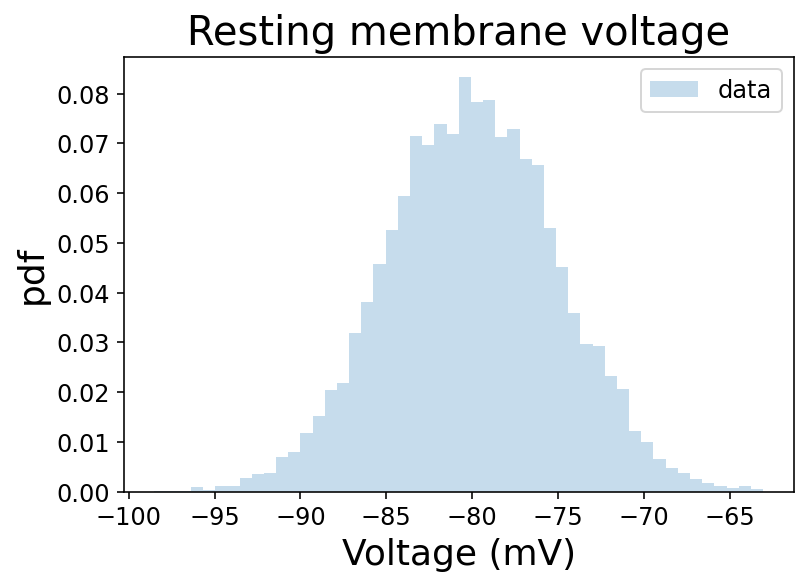

In [14]:
# Simulated data for a neuron's resting membrane voltage (mV)
# under basal conditions.
data = st.norm.rvs(-80, 5, size=(10000,))

plt.hist(data, 50, density=True, alpha=0.25, label='data')
plt.xlabel('Voltage (mV)')
plt.ylabel('pdf')
plt.title('Resting membrane voltage')
plt.legend();

What distribution would you use to describe this data?

What are your best estimates for the distribution parameters?

In [15]:
mu = data.mean()    # mean
sigma = data.std()  # standard deviation

model = st.norm(mu, sigma)  # normal distribution

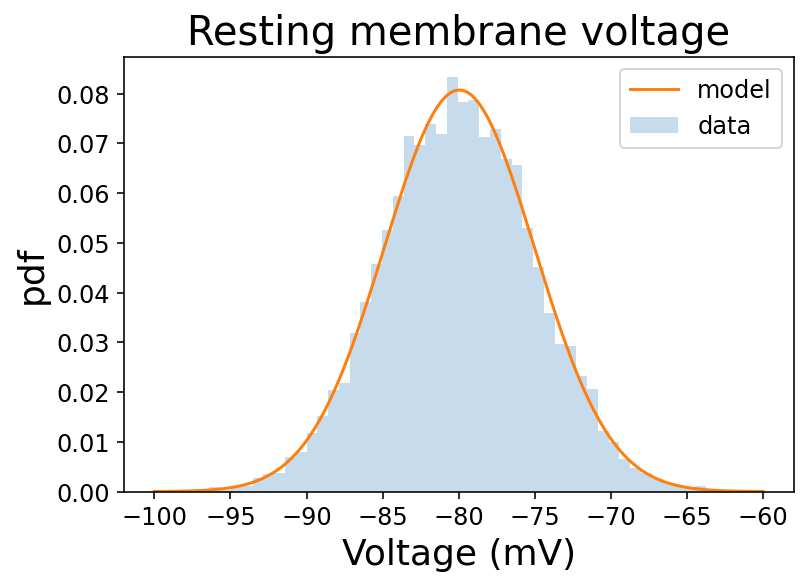

In [16]:
# data and model
plt.hist(data, 50, density=True, alpha=0.25, label='data')

x = np.linspace(-100, -60, 401)
plt.plot(x, model.pdf(x), label='model')

plt.xlabel('Voltage (mV)')
plt.ylabel('pdf')
plt.title('Resting membrane voltage')
plt.legend();

# Example

Current through an ion channel that is either closed or open.

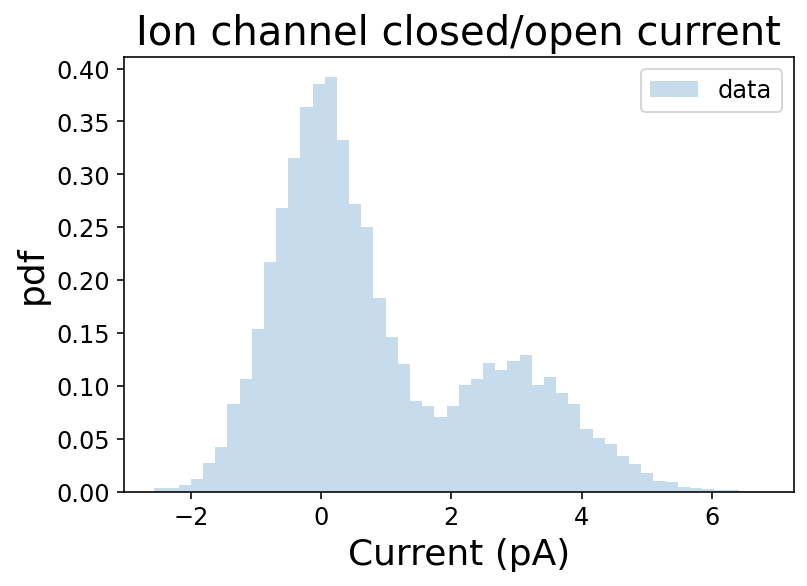

In [17]:
# simulated data for current (pA) through an ion channel that is either closed or open.
data = np.random.choice([0.0, 1.0], size=(10000,), p=[0.7, 0.3])
mask0 = data == 0
mask1 = data == 1
n0 = mask0.sum()
n1 = mask1.sum()
data[mask0] = st.norm.rvs(0, 0.75, size=(n0,))
data[mask1] = st.norm.rvs(3, 1, size=(n1,))

plt.hist(data, 50, density=True, alpha=0.25, label='data')
plt.xlabel('Current (pA)')
plt.ylabel('pdf')
plt.title('Ion channel closed/open current')
plt.legend();

What distribution would you use to describe this data?

You can construct a `new probability distribution` that is the weighted sum of two different normal distributions.

$pdf = w_1 Normal(\mu_1, \sigma_1) + w_2 Normal(\mu_2, \sigma_2)$

$\int pdf = 1 \hspace{1em} \rightarrow \hspace{1em} w_2 = 1 - w_1$

In [18]:
def my_pdf(x, params):
    w1, mu1, sigma1, mu2, sigma2 = params
    w2 = 1 - w1
    return w1 * st.norm.pdf(x, mu1, sigma1) + w2 * st.norm.pdf(x, mu2, sigma2)

How would you estimate the distribution parameters?

Let's start by taking a reasonable guess.

In [21]:
# w1, mu1, sigma1, mu2, sigma2
paramsGuess = 0.6, 0, 0.5, 3.5, 1.5

In [22]:
x = np.linspace(-3, 7, 1001)

pdfGuess = my_pdf(x, paramsGuess)

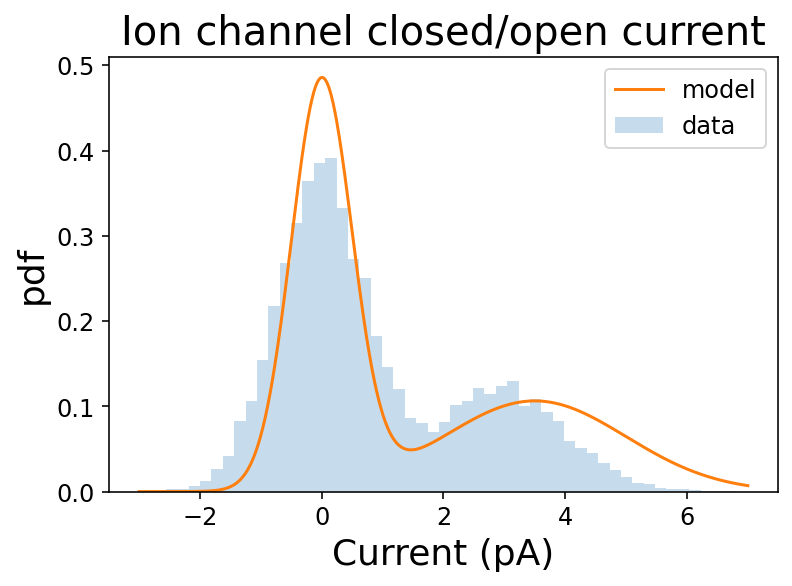

In [23]:
plt.hist(data, 50, density=True, alpha=0.25, label='data')
plt.plot(x, pdfGuess, label='model')
plt.xlabel('Current (pA)')
plt.ylabel('pdf')
plt.title('Ion channel closed/open current')
plt.legend();

Are these the best possible choice of parameters?

If not, how will you find them?

# Likelihood

The likelihood ($L$) of observing a value $x$ is simply its probability density $pdf(x)$.

$L(x) = pdf(x)$

The likelihood of observing multiple values $x_1, x_2, ..., x_N$ is simply the product of their individual likelihoods.

$L(x_1, x_2, ..., x_N) = pdf(x_1)pdf(x_2)...pdf(x_N)$

Your goal is to find the parameters that maximize the likelihood of your measured data.

Likelihood is the **product of many small numbers** that are all less than one, which for many data points becomes **VERY small VERY fast**.

$L = pdf(x_1)pdf(x_2)...pdf(x_N)$

There is a minimum value that Python can represent. If any value becomes smaller than this, it will result in an underflow ERROR.

In [14]:
import sys
sys.float_info.min

2.2250738585072014e-308

# Loglikelihood

$L = pdf(x_1)pdf(x_2)...pdf(x_N)$

$LL = log(L) = log(pdf(x_1)) + log(pdf(x_2)) + ... + log(pdf(x_N))$

The same parameters will maximize both $L$ and $LL$.

But $LL$ is unlikely to result in an underflow ERROR. Can you see why?

Thus, $LL$ is almost always used instead of $L$.

# $max(LL) \Rightarrow min(-LL)$

So, your goal is to find the parameters that **maximize the loglikelihood of your measured data**.

These same parameters will also maximize the likelihood.

However, because Python has a minimizer and not a maximizer, you will instead **minimize the negative loglikelihood of your measured data**.

You start by defining a function that returns the negative loglikelihood of your data given a set of model parameters.

In [24]:
def my_negloglikelihood(params):
    # array of probability densities for all data points given the input params
    pdf = my_pdf(data, params)
    
    # loglikelihood is the sum of the logs of the pdf's for each data point
    LL = np.sum(np.log(pdf))
    
    # return the negative loglikelihood
    return -LL

Now you want ro find the parameters that minimize the value of your negative loglikelihood function.

In [25]:
import scipy.optimize as opt

In [36]:
# w1, mu1, sigma1, mu2, sigma2
start = [0.6, 0, 0.5, 3.5, 1.5]
bnds = [(0, 1), (-2, 2), (0.01, 3), (0, 5), (0.01, 3)]

result = opt.minimize(my_negloglikelihood, start, method='slsqp', bounds=bnds)

/var/folders/k1/swt2sp1x6mj7wyc2cs76qq4m0000gn/T/ipykernel_57981/3599795356.py:6: RuntimeWarning: divide by zero encountered in log
  LL = np.sum(np.log(pdf))


In [37]:
result

     fun: 17318.273083287626
     jac: array([0.00854492, 0.00439453, 0.00219727, 0.00097656, 0.00390625])
 message: 'Optimization terminated successfully'
    nfev: 96
     nit: 14
    njev: 14
  status: 0
 success: True
       x: array([ 0.68928988, -0.01595063,  0.73033073,  2.974841  ,  1.03077043])

In [38]:
if result.success:
    params = result.x
    print(params)
else:
    print(result.message)

[ 0.68928988 -0.01595063  0.73033073  2.974841    1.03077043]


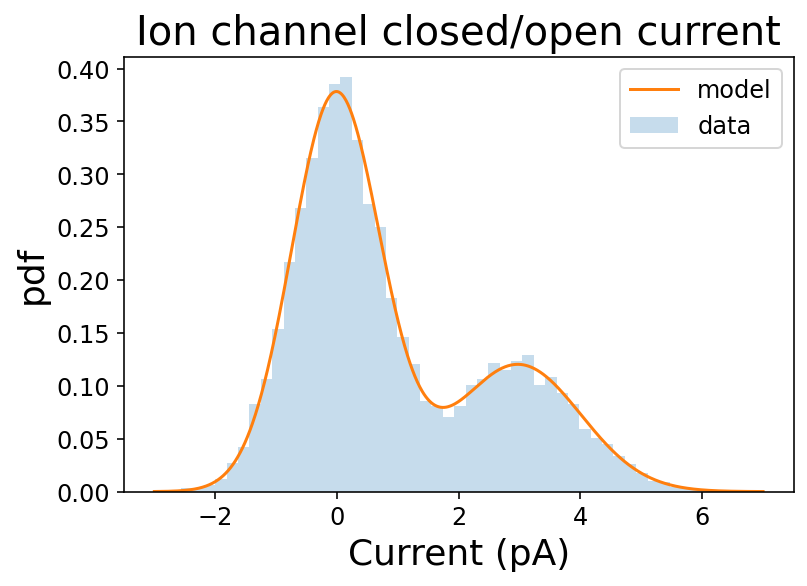

In [39]:
plt.hist(data, 50, density=True, alpha=0.25, label='data')

x = np.linspace(-3, 7, 1001)
plt.plot(x, my_pdf(x, params), label='model')

plt.xlabel('Current (pA)')
plt.ylabel('pdf')
plt.title('Ion channel closed/open current')
plt.legend();

In [40]:
w1, mu1, sigma1, mu2, sigma2 = params
w2 = 1 - w1

# mu1 = closed, mu2 = open
if mu2 < mu1:
    w1, mu1, sigma1, w2, mu2, sigma2 = w2, mu2, sigma2, w1, mu1, sigma1

print(f"Single channel current is {mu2 - mu1 :.2f} pA")
print(f"Closed and open channel noise are {sigma1 :.2f} and {sigma2 :.2f} pA, respectively")
print(f"Open probability is {w2 :.2f}")

Single channel current is 2.99 pA
Closed and open channel noise are 0.73 and 1.03 pA, respectively
Open probability is 0.31


# Example

A protein is activated by depolarizing the cell membrane, and deactivates upon repolarization by one of two possible pathways, each pathway ocurring at a different average rate. You measure the time to deactivation for a single molecule following each of 10,000 independent repolarizations (see `deact_times` below).

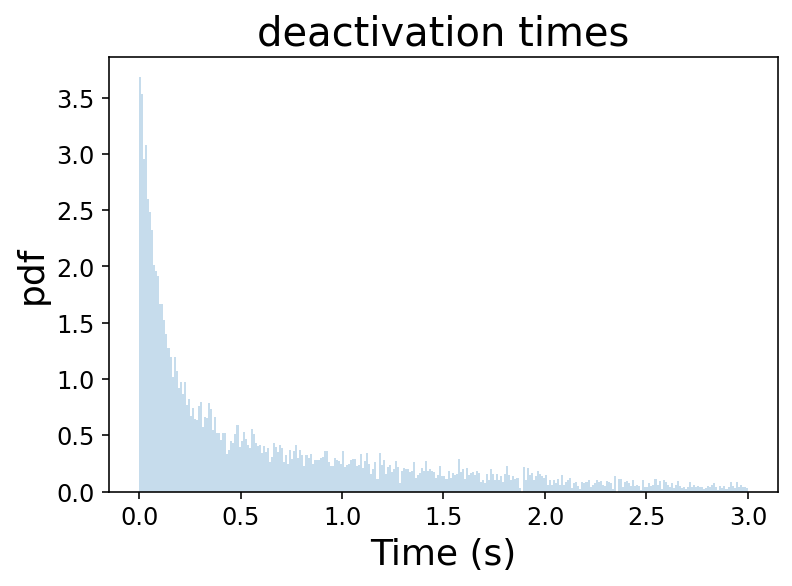

In [42]:
# Simulated deactivation times (s)
deact_times = st.expon.rvs(loc=0, scale=np.random.choice([0.1, 1.0], size=(10000,), p=[0.3, 0.7]))

plt.hist(deact_times, bins=np.linspace(0, 3, 301), density=True, alpha=0.25)
plt.xlabel('Time (s)')
plt.ylabel('pdf')
plt.title('deactivation times');

# Exercise

Use an exponential probability distribution to describe the above `deact_times` and plot the model overlaid on the data to see how well it does.

In [ ]:
model = st.expon(...)

bin_edges = np.linspace(0, 3, 301)
plt.hist(deact_times, bins=bin_edges, density=True, alpha=0.25, label='data')
plt.plot(bin_edges, model.pdf(bin_edges), label='model')
plt.xlabel('Time (s)')
plt.ylabel('pdf')
plt.title('deactivation times')
plt.legend();

# Exercise

Use the weighted sum of two different exponential distributions to describe the above `deact_times` and plot the model overlaid on the data to see how well it does.

1. Define a function for the weighted sum of two different exponential distributions.

In [ ]:
def biexp_pdf(x, params):
    ...

2. Define a function that given parameters to your custom distribution returns the negative loglikelihood of the measured deactivation times.

In [ ]:
def negLL(params):
    ...

3. Make a reasonable guess for the parameters.

In [ ]:
paramsGuess = [...]

4. Define lower and upper bounds for the parameters.

In [ ]:
bnds = [(...), ...]

5. Starting from your guess above, find the parameters within your defined bounds above that minimize the negative loglikelihood.

In [ ]:
result = opt.minimize(...)

if result.success:
    params = result.x
    print(params)
else:
    print(result.message)

6. Plot the optimized model overlaid on the data.

In [ ]:
bin_edges = np.linspace(0, 3, 301)

# model pdf at all bin edges
model_pdf = ...

plt.hist(deact_times, bins=bin_edges, density=True, alpha=0.25, label='data')
plt.plot(bin_edges, model_pdf, label='model')
plt.xlabel('Time (s)')
plt.ylabel('pdf')
plt.title('deactivation times')
plt.legend();

7. What are the average deactivation rates along each pathway according to your model?

In [ ]:
rate1 = ...
rate2 = ...

print(f"Deactivation along pathway 1 occurs at {rate1:.1f} per second.")
print(f"Deactivation along pathway 2 occurs at {rate2:.1f} per second.")

8. How often does the model predict that each pathway is taken?

In [ ]:
w1 = ...
w2 = ...

print(f"Pathways 1 and 2 are traversed {w1*100:.0f}% and {w2*100:.0f}% of the time, respectively.")

# General optimization

The minimization approach that we have applied to find the parameters that maximize the likelihood of a probability distribution is generally applicable to many other optimization problems.

# Example: Curve fitting 

Consider the decay time course of an excitatory postsynaptic current (EPSC).

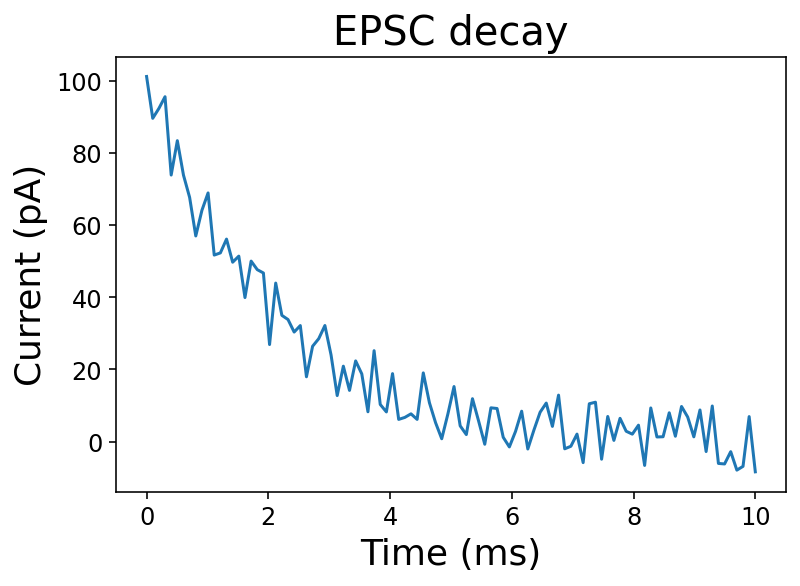

In [45]:
time_ms = np.linspace(0, 10, 100)
epsc_decay_pA = 100 * np.exp(-time_ms / 2) + 20 * (np.random.rand(len(time_ms)) - 0.5)

plt.plot(time_ms, epsc_decay_pA)
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)')
plt.title('EPSC decay');

Define a function to model the EPSC decay.

In [46]:
def my_decay(time, params):
    amp, tau = params
    return amp * np.exp(-time / tau)

Define a cost function that returns the sum of squared errors (SSE) between the model function above and the EPSC data.

In [47]:
def sse(params):
    return np.sum((epsc_decay_pA - my_decay(time_ms, params))**2)

Find the model parameters that minimize the SSE between the model decay and the EPSC data.

In [48]:
start = [80, 4]
result = opt.minimize(sse, start, method='slsqp', bounds=[(50, 150), (0.1, 10)])
result

     fun: 3306.809026442292
     jac: array([0.        , 0.00366211])
 message: 'Optimization terminated successfully'
    nfev: 40
     nit: 12
    njev: 12
  status: 0
 success: True
       x: array([100.5643749 ,   2.01278433])

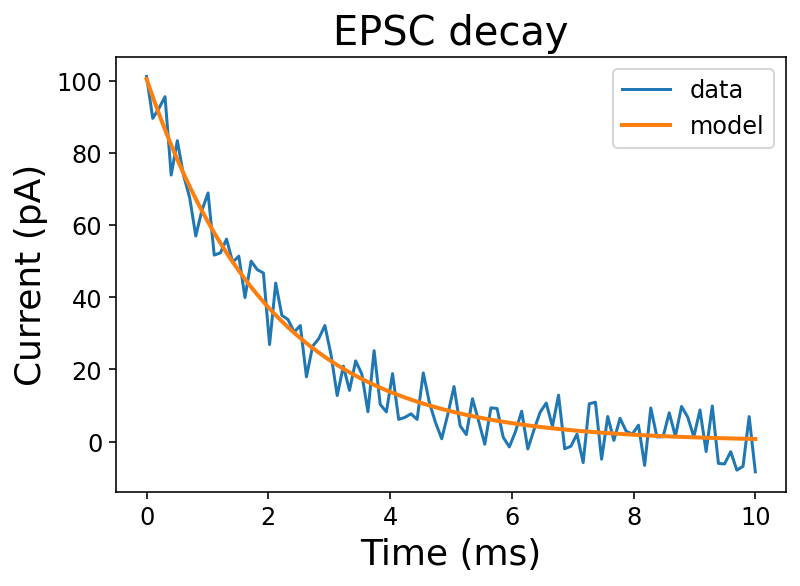

In [49]:
plt.plot(time_ms, epsc_decay_pA, label='data')
plt.plot(time_ms, my_decay(time_ms, result.x), label='model', lw=2)
plt.xlabel('Time (ms)')
plt.ylabel('Current (pA)')
plt.title('EPSC decay')
plt.legend();

Visualize the 2D SSE surface that we were searching for a minimum on in the EPSC decay example above.

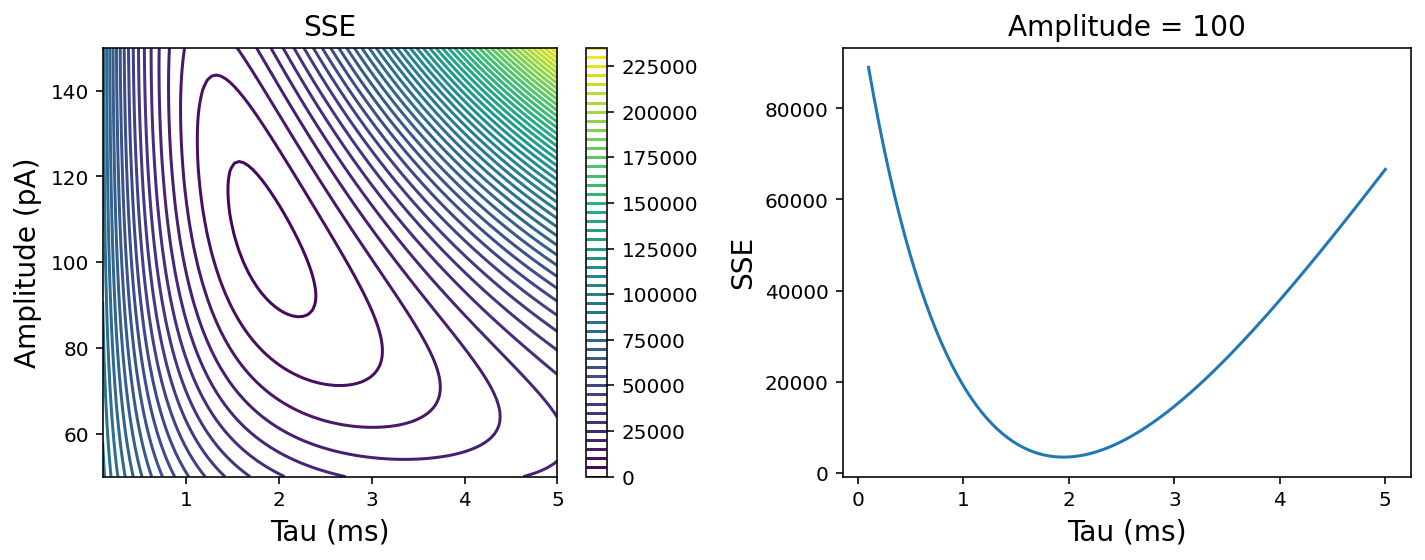

In [69]:
# SSE surface
amps = np.linspace(50, 150, 101)
taus = np.linspace(0.1, 5, 101)

cost = np.zeros((len(amps), len(taus)))

for i, amp in enumerate(amps):
    for j, tau in enumerate(taus):
        cost[i,j] = sse([amp, tau])

plt.figure(figsize=(10,4))
# rows = amps, columns = taus ==> x = taus, y = amps
plt.subplot(1, 2, 1)
plt.contour(taus, amps, cost, 50)
# plt.hlines(amps[50], taus[0], taus[-1])
plt.xlabel('Tau (ms)')
plt.ylabel('Amplitude (pA)')
plt.title('SSE')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.plot(taus, cost[50,:])
plt.xlabel('Tau (ms)')
plt.ylabel('SSE')
plt.title(f'Amplitude = {amps[50]:.0f}')
plt.tight_layout();

It is difficult to visualize, but mathematically simple to find a minimum in three or more dimensions (i.e, three or more parameters).

# Gradient Descent

![Gradient Descent](images/gradient-descent.gif)

# Global vs Local Minima

![Global vs Local Minima](images/local-global-minima.png)

Consider a simple cost function with two local minima and one global minima.

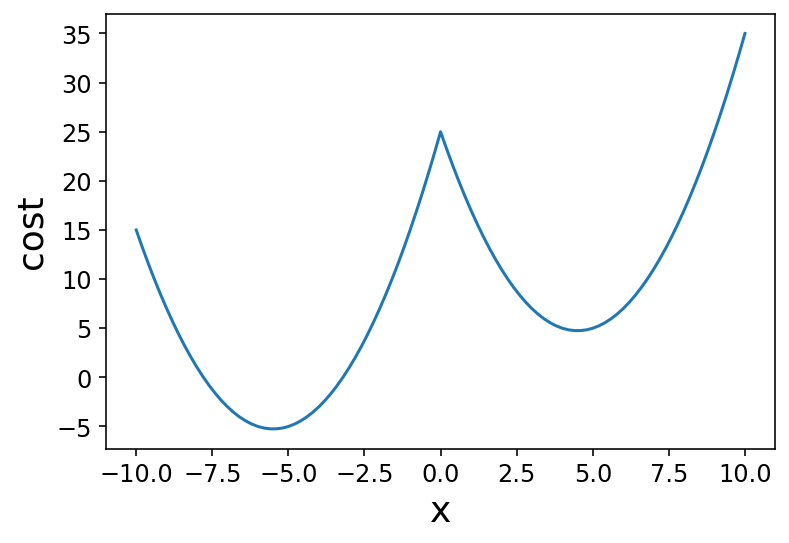

In [50]:
def cost(x):
    return (abs(x) - 5)**2 + x

x = np.linspace(-10, 10, 101)
plt.plot(x, cost(x))
plt.xlabel('x')
plt.ylabel('cost');

Find the minima starting at either $x=-10$ or $x=+10$.

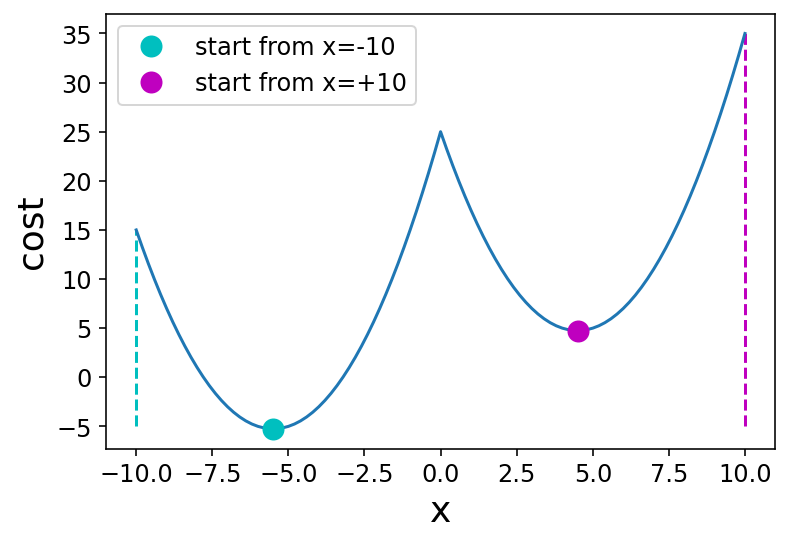

In [51]:
result_from_left = opt.minimize(cost, [-10])
xmin_from_left = result_from_left.x[0]

result_from_right = opt.minimize(cost, [+10])
xmin_from_right = result_from_right.x[0]

plt.plot(x, cost(x))
plt.plot(xmin_from_left, cost(xmin_from_left), 'co', ms=10, label='start from x=-10')
plt.plot(xmin_from_right, cost(xmin_from_right), 'mo', ms=10, label='start from x=+10')
plt.vlines(-10, -5, 15, 'c', ls='--')
plt.vlines(+10, -5, 35, 'm', ls='--')
plt.xlabel('x')
plt.ylabel('cost')
plt.legend();

# Global Minima

![Local vs Global Minima](images/local-global-minima.png)

There are a number of methods that attempt to find the global minima rather than the nearest local minima.

[e.g. basin hopping, brute force, annealing, SHG.](https://docs.scipy.org/doc/scipy/reference/optimize.html)

Find global minimum using dual annealing.

In [52]:
# find value global minimum within the range -10 <= x <= 10.
result = opt.dual_annealing(cost, bounds=[(-10, 10)])

result

     fun: array([-5.25])
 message: ['Maximum number of iteration reached']
    nfev: 2007
    nhev: 0
     nit: 1000
    njev: 3
  status: 0
 success: True
       x: array([-5.5])

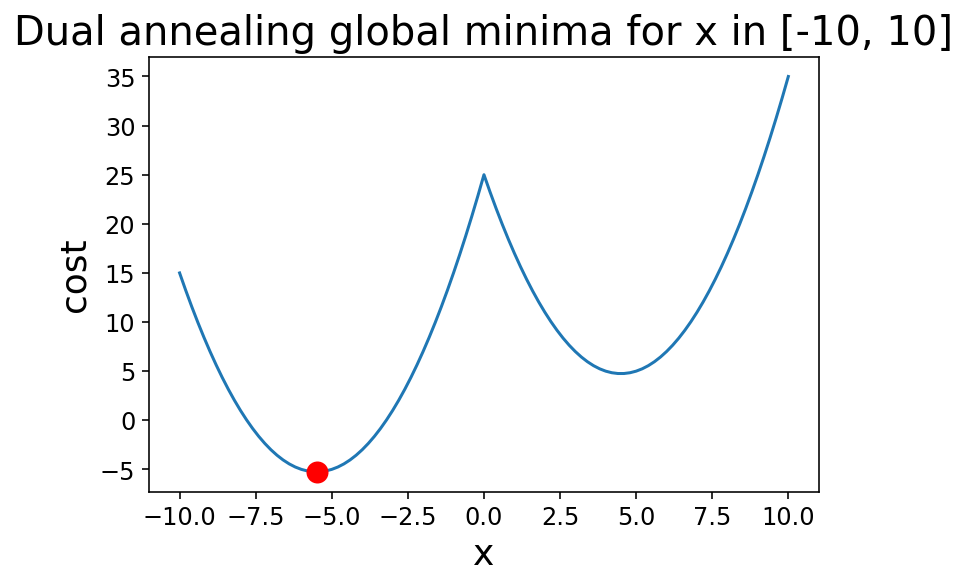

In [53]:
xmin = result.x[0]

plt.plot(x, cost(x))
plt.plot(xmin, cost(xmin), 'ro', ms=10)
plt.xlabel('x')
plt.ylabel('cost')
plt.title('Dual annealing global minima for x in [-10, 10]');